In [6]:
import sys, itertools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn, time, math
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

if '../tools' not in sys.path:
    sys.path.append('../tools')
from helper_functions import * 

import warnings
warnings.filterwarnings('ignore')

In [9]:
def log_range(lo, hi): return [10 ** i for i in range(lo, hi)]
    
def best(scores, hypers):
    best = max(scores)
    return best, hypers[scores.index(best)]

def run(X, Y, hypers, classifier, data_change=None):
    hypers = list(hypers)
    best_acc, best_params = -np.inf, None
    skf = StratifiedKFold(Y, n_folds=8, shuffle=True, random_state=1)
    scores = []
    nproc = 8
    for i, h in enumerate(hypers):
        svm = classifier(h)
        mX = X
        if data_change: mX = data_change(mX, h)
        c = np.average(cross_val_score(svm, mX, Y, cv=skf, n_jobs=-1))
        scores.append(c)
        print('\r{} best acc {} params {}'.format(
                completion_bar(len(scores), len(hypers), width=20),
                *best(scores, hypers)), end='')
        sys.stdout.flush()
    print()
    return best(scores, hypers)


In [107]:
df = ['ovo', 'ovr']
Cs = log_range(-5, 5)
kernels = ['rbf', 'poly']
def make_svm(tup):
    C, k, d = tup
    if k == 'poly': return SVC(C=C, kernel=k, decision_function_shape=d, degree=10., coef0=1.)
    return SVC(C=C, kernel=k, decision_function_shape=d)

M, Y = load_all_fv(3, 3)
C, Y = load_chroma_fv(3, 3)

top_mfcc_svm, top_chroma_svm = None, None

print('mfcc(3,3) on SVM (hyper is C, kernel, ovo/ovr)')
top_mfcc_svm = run(M, Y, itertools.product(Cs, kernels, df), make_svm)

loss = ['hinge', 'squared_hinge']
def make_lsvm(tup):
    C, l = tup
    return LinearSVC(C=C, loss=l)
print('mfcc(3,3) on LinearSVM (hyper is C, kernel, ovo/ovr)')
x = run(M, Y, itertools.product(Cs, loss), make_lsvm)
if x[0] > top_mfcc_svm[0]: top_mfcc_svm = make_lsvm(x[1])
else: top_mfcc_svm = make_svm(top_mfcc_svm[1])

print('chroma(3,3) on SVM (hyper is C, kernel, ovo/ovr)')
top_chroma_svm = run(C, Y, itertools.product(Cs, kernels, df), make_svm)

print('chroma(3,3) on LinearSVM (hyper is C, kernel)')
x = run(C, Y, itertools.product(Cs, loss), make_lsvm)
if x[0] > top_chroma_svm[0]: top_chroma_svm = make_lsvm(x[1])
else: top_chroma_svm = make_svm(top_chroma_svm[1])

Using existing FVs from file ../generated-fv/FV3-3.mat
N = 1000
MFCC training feature ranges means [-0.0201, 0.0090] sds [0.0202, 0.0614]
Using existing FVs from file ../generated-fv/FVC3-3.mat
N = 1000
chroma training feature ranges means [-0.0107, 0.0108] sds [0.0376, 0.0670]
mfcc(3,3) on SVM (hyper is C, kernel, ovo/ovr)
[--------------------] 40/40 best acc 0.6744391025641026 params (100, 'poly', 'ovo')
mfcc(3,3) on LinearSVM (hyper is C, kernel, ovo/ovr)
[--------------------] 20/20 best acc 0.6481570512820513 params (1, 'squared_hinge')
chroma(3,3) on SVM (hyper is C, kernel, ovo/ovr)
[--------------------] 40/40 best acc 0.47508012820512824 params (1000, 'poly', 'ovo')
chroma(3,3) on LinearSVM (hyper is C, kernel)
[--------------------] 20/20 best acc 0.47187500000000004 params (10, 'squared_hinge')


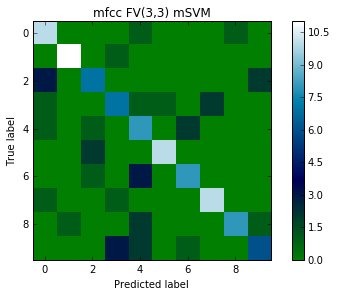

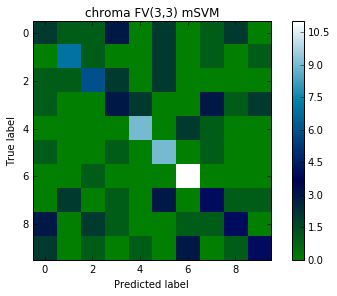

In [10]:
trM, teM, trC, teC, trY, teY = train_test_split(M, C, Y, stratify=Y,
                                      random_state=1, test_size=(1/8))
top_mfcc_svm.fit(trM, trY)
plot_confusion_matrix(confusion_matrix(teY, top_mfcc_svm.predict(teM)),
                      title='mfcc FV(3,3) mSVM')
plt.show()
top_mfcc_svm.fit(trC, trY)
plot_confusion_matrix(confusion_matrix(teY, top_mfcc_svm.predict(teC)),
                      title='chroma FV(3,3) mSVM')
plt.show()

In [16]:
df = ['ovo', 'ovr']
Cs = log_range(-5, 5)
kernels = ['rbf', 'poly']
def make_svm(tup):
    C, k, d = tup
    if k == 'poly': return SVC(C=C, kernel=k, decision_function_shape=d, degree=10., coef0=1.)
    return SVC(C=C, kernel=k, decision_function_shape=d)
svm = make_svm(run(X, Y, itertools.product(Cs, kernels, df), make_svm)[1])

[--------------------] 40/40 best acc 0.6842147435897437 params (100, 'poly', 'ovo')


mfcc(3,3)+chroma(3,3) on SVM (hyper is C, k)
[--------------------] 7/7 best acc 0.6842147435897437 params 100


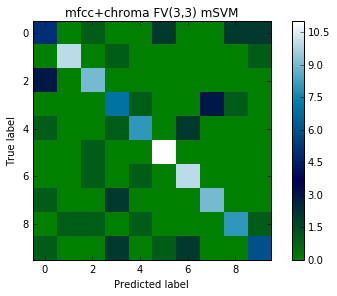

In [14]:
def make_svm(C):
    return SVC(C=C, kernel='poly',
               decision_function_shape='ovo',
               degree=10., coef0=1.)
Cs = log_range(0, 7)

X = np.concatenate((M, C), axis=1)
trX, teX, trY, teY = train_test_split(X, Y, stratify=Y,
                                      random_state=1, test_size=(1/8))

print('mfcc(3,3)+chroma(3,3) on SVM (hyper is C, k)')
svm = make_svm(run(X, Y, Cs, make_svm)[1])

svm.fit(trX, trY)
plot_confusion_matrix(confusion_matrix(teY, svm.predict(teX)),
                      title='mfcc+chroma FV(3,3) mSVM')

In [ ]:
M, Y = load_all_fv(8, 8)
C, Y = load_chroma_fv(8, 8)
X = np.concatenate((M, C), axis=1)
print('mfcc(8,8) on SVM (hyper is C, k)')
run(M, Y, itertools.product(Cs, kernels), make_svm)
print('chroma(8,8) on SVM (hyper is C, k)')
run(C, Y, itertools.product(Cs, kernels), make_svm)
print('mfcc(8,8)+chroma(8,8) on SVM (hyper is C, k)')
run(X, Y, itertools.product(Cs, kernels), make_svm)

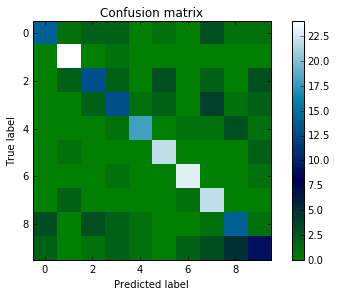

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
def make_rf(md):
    return RandomForestClassifier(n_estimators=(max(md,10)*6), max_depth=md)

df = ['ovo', 'ovr']
Cs = log_range(-5, 5)
kernels = ['rbf', 'poly']
def make_svm(tup):
    C, k, d = tup
    if k == 'poly': return SVC(C=C, kernel=k, decision_function_shape=d, degree=10., coef0=1.)
    return SVC(C=C, kernel=k, decision_function_shape=d)
svm = make_svm(run(X, Y, itertools.product(Cs, kernels, df), make_svm)[1])

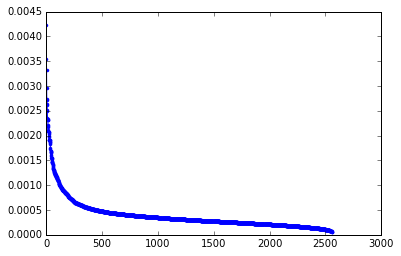

In [59]:
rf.fit(X, Y) # can't technically do whole, integrate this with CV
def order(x):
    p = [x[0] for x in sorted(list(enumerate(x)), key=lambda tup:tup[1])]
    p.reverse()
    return p
p = order(rf.feature_importances_)
plt.plot(rf.feature_importances_[p], '.-')
plt.show()

In [ ]:
print('RF-cutoff mfcc/chroma + SVM (hyper is C regularizer)')
run(whiten(X[:, p[:1000]]), Y, log_range(0, 10), lambda C: SVC(C=C))
print('RF-cutoff mfcc/chroma + poly SVM (hyper is C regularizer)')
run(whiten(X[:, p[:1000]]), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='poly', degree=10, coef0=1))
print('RF-cutoff mfcc/chroma + linear SVM (hyper is C regularizer)')
run(whiten(X[:, p[:1000]]), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='linear'))
print('RF-scaled mfcc/chroma + rbf SVM (hyper is C regularizer)')
run(rf.feature_importances_ * 1000 * whiten(X), Y, log_range(0, 10), lambda C: SVC(C=C))
print('RF-scaled mfcc/chroma + poly SVM (hyper is C regularizer)')
run(rf.feature_importances_ * 1000 * whiten(X), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='poly', degree=10, coef0=1))
print('RF-scaled mfcc/chroma + linear SVM (hyper is C regularizer)')
run(rf.feature_importances_ * 1000 * whiten(X), Y, log_range(0, 10),
    lambda C: SVC(C=C, kernel='linear'))

RF-cutoff mfcc + rbf SVM (hyper is C regularizer)
[--------------------] 1/1 best acc 0.535176 hyper 5
done in 0.8084800243377686 seconds
[--------------------] 1/1 best acc 0.588462 hyper 5
done in 0.990833044052124 seconds
[--------------------] 1/1 best acc 0.639904 hyper 5
done in 1.398914098739624 seconds
[--------------------] 1/1 best acc 0.667067 hyper 5
done in 1.706181526184082 seconds
[--------------------] 1/1 best acc 0.683173 hyper 5
done in 2.213334083557129 seconds
[--------------------] 1/1 best acc 0.694952 hyper 5
done in 2.5045533180236816 seconds
[--------------------] 1/1 best acc 0.712821 hyper 5
done in 3.2288362979888916 seconds
[--------------------] 1/1 best acc 0.715946 hyper 5
done in 3.5558834075927734 seconds
[--------------------] 1/1 best acc 0.714824 hyper 5
done in 3.6879754066467285 seconds
[--------------------] 1/1 best acc 0.720753 hyper 5
done in 4.029447078704834 seconds
[--------------------] 1/1 best acc 0.71875 hyper 5
done in 4.9164564609527

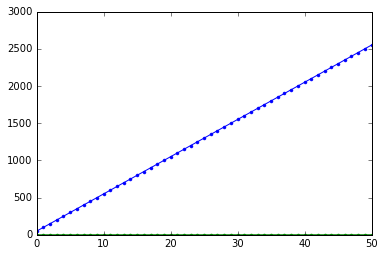

In [16]:
def runRBF5(X, k):
    print('RF-cutoff mfcc + rbf SVM (hyper is C regularizer), cutoff', k)
    return run(whiten(X[:, p[:k]]), Y, [5], lambda C: SVC(C=C))
print('RF-cutoff mfcc + rbf SVM (hyper is C regularizer)')
ks = list(range(50, X.shape[1], 50))
res = [runRBF5(X, k)[0] for k in ks]
plt.plot(res, '.-')

Using existing FVs from file ../generated-fv/FV8-3.mat
N = 1000
MFCC training feature ranges means [-0.0119, 0.0060] sds [0.0119, 0.0429]
Using existing FVs from file ../generated-fv/FVC8-3.mat
N = 1000
chroma training feature ranges means [-0.0079, 0.0084] sds [0.0170, 0.0492]
voting score 0.716


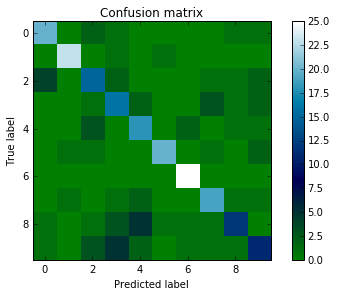

In [63]:
X, Y = load_all_fv(8, 3)
C, Y = load_chroma_fv(8, 3)
from sklearn.ensemble import VotingClassifier

trX, teX, trC, teC, trY, teY = train_test_split(X, C, Y, stratify=Y)

mfccSVM = SVC(C=1000, probability=True)
chromaSVM = SVC(C=1000, probability=True)
mfccRF = RandomForestClassifier(n_estimators=200, max_depth=30)
chromaRF = RandomForestClassifier(n_estimators=200, max_depth=30)
ests = [('mfccSVM', mfccSVM), ('chromaSVM', chromaSVM), ('mfccRF', mfccRF), ('chromaRF', chromaRF)]

mfccRF.fit(trX, trY)
chromaRF.fit(trC, trY)

top_mfcc = order(mfccRF.feature_importances_)
top_chroma = order(chromaRF.feature_importances_)

trX, teX = trX[:, top_mfcc[:1000]], teX[:, top_mfcc[:1000]]
#trC, teC = trC[:, top_chroma[:400]], teC[:, top_chroma[:400]]
mfccSVM.fit(trX, trY)
chromaSVM.fit(trC, trY)

sum_p = sum((2 * mfccSVM.predict_proba(teX), chromaSVM.predict_proba(teC), chromaRF.predict_proba(teC)))
Yhat = np.argmax(sum_p, axis=1) + 1
print('voting score', np.sum(Yhat == teY) / len(teY))
plot_confusion_matrix(confusion_matrix(teY, Yhat))
plt.show()

Below is a bunch of random classifiers also attempted

In [ ]:
# Stanford mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# This requires a new convex program formulation, unsupported within-python.

In [ ]:
class DummyPredictor:
    def __init__(self, res):
        self._res = res
    def predict(self, X):
        Y = np.empty([len(X), 1])
        Y.fill(self._res)
        return Y
        
def find_best(subsets, X, origY, C):
    best_accuracy, best_classifier, best_set = -np.inf, None, None
    val = int(0.8 * len(X))
    for subset in subsets:
        Y = np.array([y in subset for y in origY])
        svm = SVC(C=C).fit(X[:val], Y[:val])
        acc = svm.score(X[val:], Y[val:])
        if acc > best_accuracy:
            best_accuracy = acc
            best_classifier = svm
            best_set = subset
    return best_accuracy, best_classifier, best_set
    
def best_subset_finder(labels, C=1.0):
    assert len(labels) > 0
    if len(labels) == 1:
        return {}, DummyPredictor(next(iter(labels))), {}
    if len(labels) == 2:
        return {}, SVC(C=C).fit(trXadj, trY), {}
    
    subsets = []
    for i in range(1, len(labels) // 2 + 1):
        for subset in itertools.combinations(labels, i):
            subsets.append(subset)
    p = np.random.permutation(len(trXadj))
    pX = trXadj[p]
    pY = trY[p]
    
    nproc = 4
    print('  Launching {} parallel tasks for {} problems.'.format(nproc, len(subsets)))
    sys.stdout.flush()
    np.random.shuffle(subsets)
    
    best_parallel = Parallel(n_jobs=2, backend='threading') \
        (delayed(find_best)(i, pX, pY, C) for i in chunks(subsets, max(len(subsets) // nproc, 1)))
    best_accuracy, best_set, best_classifier = -np.inf, None, None
    for job_best_acc, job_best_classifier, job_best_set in best_parallel:
         if job_best_acc > best_accuracy:
             best_accuracy = job_best_acc
             best_classifier = job_best_classifier
             best_set = set(job_best_set)
         
    other = labels - best_set
    print('  Split on 0/1 for {} vs {}, validation acc {}'.format(
        best_set, other, best_accuracy))
    sys.stdout.flush()
    assert best_classifier
    return best_set, best_classifier, other

class DTree(object):
    def __init__(self, classifier, lset, rset):
        self.lset = lset
        self.rset = rset
        self.left = None
        self.right = None
        self.classifier = classifier

def binary_dtree(labels, C=10.0, debug_print_level=None):
    dbp = debug_print_level
    if dbp: print('Level {}'.format(dbp))
    left, svm, right = best_subset_finder(labels)
    if not left: assert not right
    x = DTree(svm, left, right)
    if not left: return x
    x.left = binary_dtree(left, C=(C * len(left) / len(labels)),
                          debug_print_level=(dbp + '0' if dbp else None))
    x.right = binary_dtree(right, C=(C * len(right) / len(labels)),
                           debug_print_level=(dbp + '1' if dbp else None))
    return x

In [ ]:
bdt = binary_dtree(set(trY), C=10.0, debug_print_level='r')

In [ ]:
#What if we retrain on the whole training dataset?
def dtree_predict(dt, x):
    y = dt.classifier.predict([x])[0]
    if not dt.left: return y
    subtree = dt.left if y else dt.right
    return dtree_predict(subtree, x)

def vec_dtree_predict(dt, X):
    return np.array([dtree_predict(dt, x) for x in X])

np.sum(vec_dtree_predict(bdt, teXadj) == teY) / len(teY)